### Question 3
Pick any other dataset of your choice and use appropriate modeling (atleast
two different) of class conditional densities and compare their performance on
two different modeling.

In [1]:
import warnings
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')

## Load dataclassification_report

In [2]:
NUM_CLASSES = 5
CLASSES_TO_KEEP = [1, 2, 3, 4]

In [3]:
data = pd.read_csv('california.csv')
data.target = np.floor(data.target * NUM_CLASSES/5).astype('uint8')
data = data[data.target.apply(lambda x: x in CLASSES_TO_KEEP)]
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3
2,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2
3,2.1250,50.0,4.242424,1.071970,697.0,2.640152,37.85,-122.26,1
4,1.9911,50.0,5.343675,1.085919,990.0,2.362768,37.84,-122.26,1


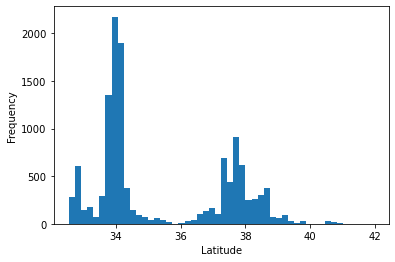

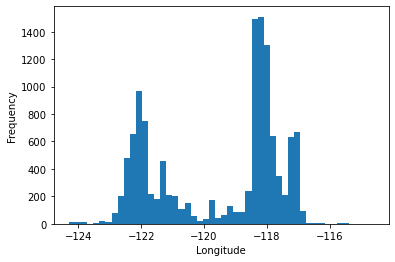

In [4]:
plt.hist(data['Latitude'], bins=50)
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.show()
plt.hist(data['Longitude'], bins=50)
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.show()

## Stratify

In [5]:
train, test = train_test_split(data, stratify=data.target, random_state=42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'Test distribution')

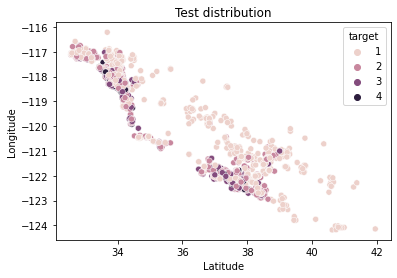

In [6]:
sns.scatterplot(x='Latitude', y='Longitude', hue='target', data=test)
plt.xlabel('Latitude')
plt.ylabel("Longitude")
plt.title('Test distribution')

## Normalize

In [7]:
mu = train.loc[:,:'Longitude'].mean()
sigma = train.loc[:,:'Longitude'].std()

train.loc[:,:'Longitude'] = (train.loc[:,:'Longitude'] - mu) / sigma
test.loc[:,:'Longitude'] = (test.loc[:,:'Longitude'] - mu)/sigma

## Verify stratification and priors

In [8]:
priors = pd.DataFrame({
    'train': train.target.value_counts() / len(train),
    'test' : test.target.value_counts() / len(test)
})
priors

,train,test
1,0.510517,0.510463
2,0.324807,0.324667
3,0.123454,0.123653
4,0.041222,0.041218


## Class conditionals

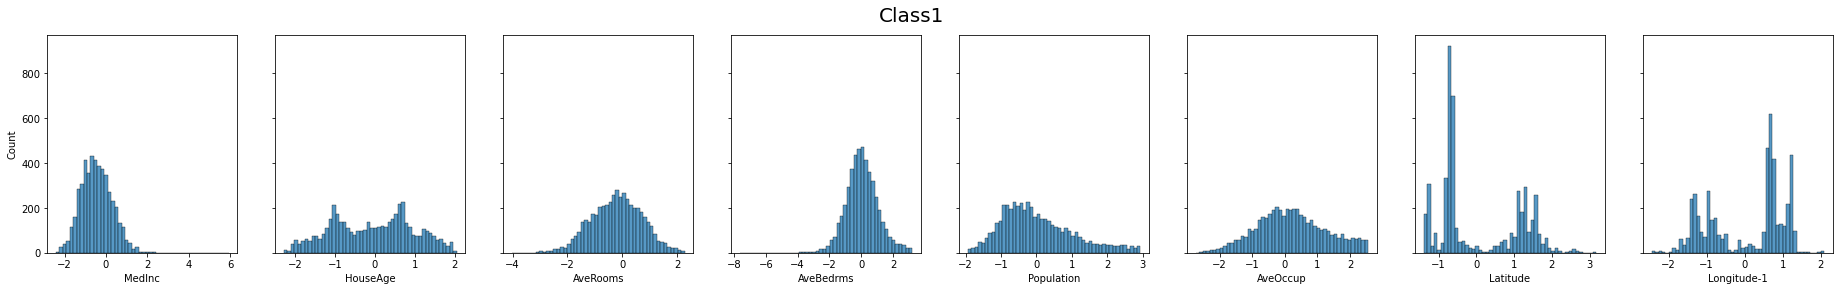

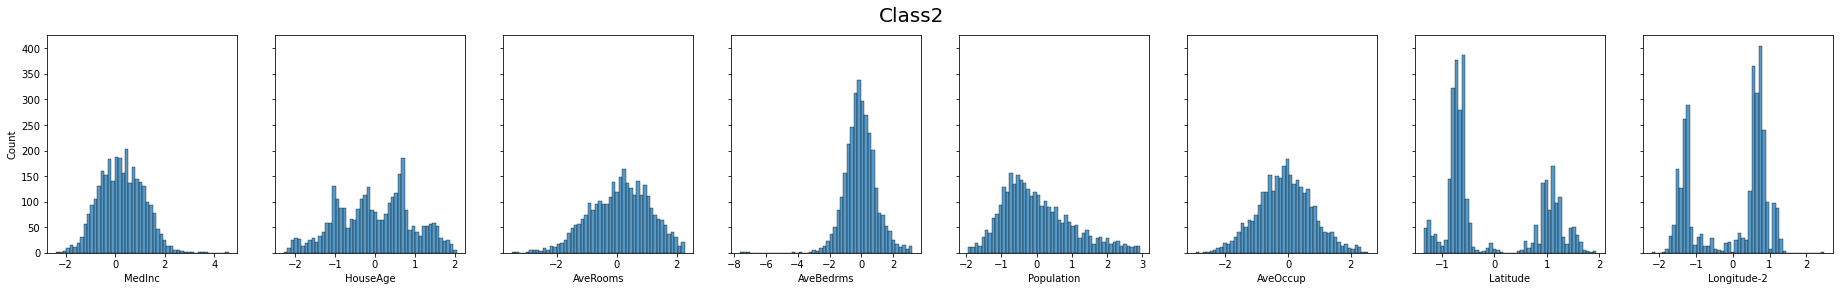

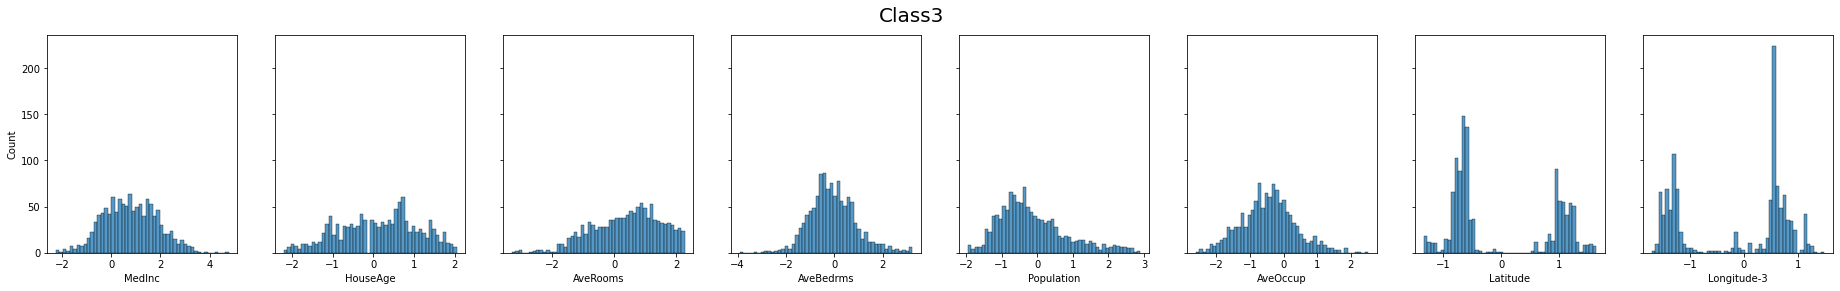

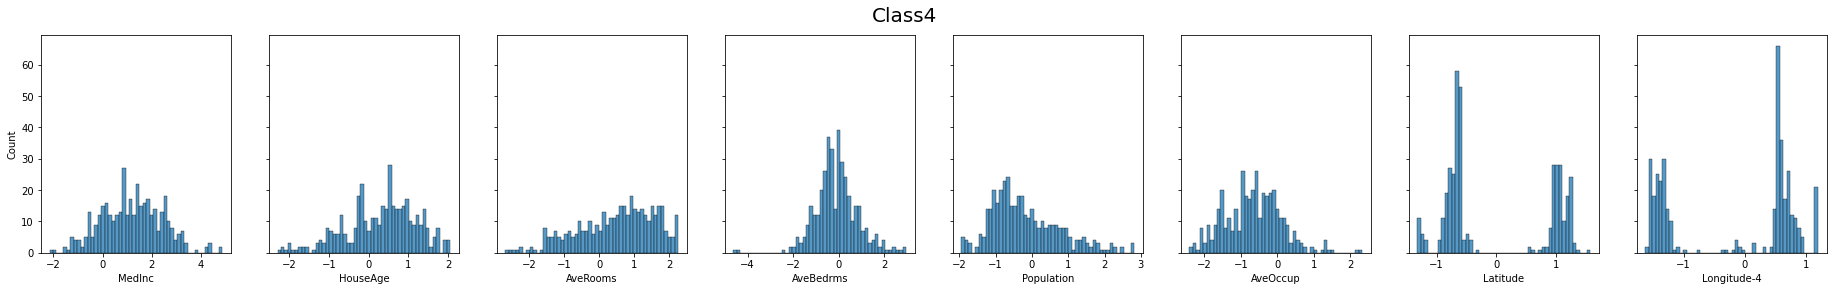

In [9]:
for c in np.unique(train.target):
    fig, axs = plt.subplots(1, 8, figsize=(32, 4), sharey=True)
    fig.suptitle(f'Class{c}', fontsize=20)
    for i, col in enumerate(train):
        if col == 'target':
            continue
        sns.histplot(train[col][train.target == c], bins=50, ax=axs[i])
        plt.xlabel(f"{col}-{c}")   
    plt.show()


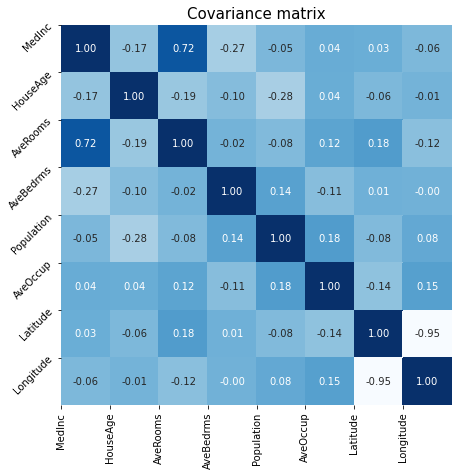

In [10]:
x = train.loc[:,:'Longitude']
cov = np.cov(x, rowvar=False)

plt.figure(figsize=(7, 7))
sns.heatmap(cov, annot=True, fmt='.2f', cbar=False, cmap="Blues")
plt.title(f"Covariance matrix", fontsize=15)
plt.xticks(range(8), list(x), rotation=90);
plt.yticks(range(8), list(x), rotation=45);

## Baseline using Gaussian Naive Bayes library

In [11]:
model = GaussianNB().fit(train.loc[:,:'Longitude'], train.target)
preds = model.predict(train.loc[:,:'Longitude'])
print("Train Accuracy: ", (train.target == preds).mean())

preds = model.predict(test.loc[:,:'Longitude'])
print("Test Accuracy: ", (test.target == preds).mean())

Train Accuracy:  0.6112461684811331
Test Accuracy:  0.6179454660748256


## Purely Gaussian Model

Train accuracy:  0.6705422259803403
Test accuracy:  0.6778693722257451
              precision    recall  f1-score   support

           1       0.83      0.77      0.80      1610
           2       0.55      0.71      0.62      1024
           3       0.51      0.36      0.43       390
           4       0.49      0.23      0.31       130

    accuracy                           0.68      3154
   macro avg       0.60      0.52      0.54      3154
weighted avg       0.69      0.68      0.67      3154



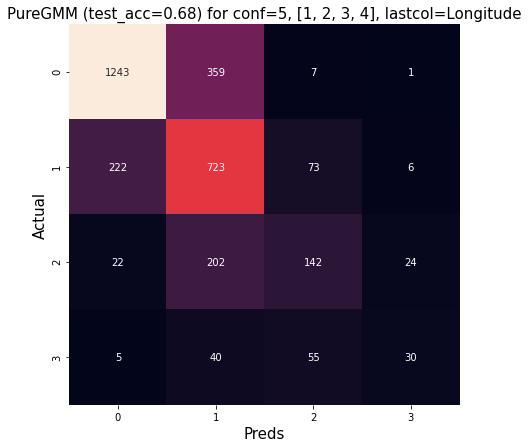

In [12]:
class ClassConditionalGaussianModel:
    def __init__(self, prior, mean, covInv, covDet):
        self.prior = prior
        self.mean = mean
        self.covInv = covInv
        self.denominator = np.sqrt(covDet)
        
    def posteriorProbScaled(self, x):
        z = x - self.mean
        numerator = self.prior * np.exp(-0.5 * np.diagonal(z @ self.covInv @ z.T) )
        return numerator/self.denominator

def predict(models, x):
    if type(x) != np.ndarray:
        x = np.array(x)
    idx = np.array([model.posteriorProbScaled(x) for model in models]).T.argmax(axis=1)
    return np.array(CLASSES_TO_KEEP)[idx]

def getModels(train, classes=CLASSES_TO_KEEP):
    X = np.array(train.loc[:,:LAST_COL])
    y = np.array(train.target)
    
    idx = [y==i for i in classes] # X[idx[0]] gives all examples with target class 0
    priors = [j.mean() for j in idx] # priors is fraction of times each class appears in the dataset
    
    means = [ X[j].mean(axis=0) for j in idx ] #classwise means
    
    covs = [ np.cov(X[j], rowvar=False) for j in idx ]
    covInvs = [ np.linalg.inv(c) for c in covs ]
    covDets = [ np.linalg.det(c) for c in covs ]
    
    return [        
        ClassConditionalGaussianModel(priors[i], means[i], covInvs[i], covDets[i])
        for i in range(len(classes))
    ]

LAST_COL = 'Longitude'
models = getModels(train)

preds = predict(models, train.loc[:,:LAST_COL])
print("Train accuracy: ", (train.target == preds).mean())

preds = predict(models, test.loc[:,:LAST_COL])
acc = (test.target == preds).mean()
print("Test accuracy: ", acc)

print(classification_report(test.target, preds))

cm = confusion_matrix(test.target, preds)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False)
plt.title(f"PureGMM (test_acc={acc.round(2)}) for conf={NUM_CLASSES}, {CLASSES_TO_KEEP}, lastcol={LAST_COL}", fontsize=15)
plt.xlabel('Preds', fontsize=15)
plt.ylabel('Actual', fontsize=15);

Text(0.5, 1.0, 'Predicted distribution')

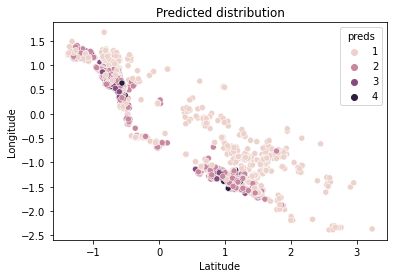

In [13]:
sns.scatterplot(x='Latitude', y='Longitude', hue='preds', data=pd.DataFrame({'Latitude':test.Latitude, 'Longitude':test.Longitude, 'preds':preds}))
plt.xlabel('Latitude')
plt.ylabel("Longitude")
plt.title('Predicted distribution')

In [14]:
for idx, model in enumerate(models):
    print(f"Class={idx}")
    print(model.mean*sigma + mu)
    print()

Class=0
MedInc           3.341832
HouseAge        27.183851
AveRooms         4.985660
AveBedrms        1.047057
Population    1336.978882
AveOccup         2.955519
Latitude        35.483203
Longitude     -119.360783
dtype: float64

Class=1
MedInc           4.354745
HouseAge        27.893264
AveRooms         5.329612
AveBedrms        1.038592
Population    1332.758868
AveOccup         2.767914
Latitude        35.238568
Longitude     -119.550836
dtype: float64

Class=2
MedInc           5.134097
HouseAge        29.384418
AveRooms         5.642253
AveBedrms        1.038454
Population    1223.518836
AveOccup         2.561737
Latitude        35.344914
Longitude     -119.789144
dtype: float64

Class=3
MedInc           5.712842
HouseAge        31.407692
AveRooms         5.744975
AveBedrms        1.036794
Population    1194.643590
AveOccup         2.436345
Latitude        35.362026
Longitude     -119.837205
dtype: float64



Train accuracy:  0.6495085086143114
Test accuracy:  0.6585288522511097
              precision    recall  f1-score   support

           1       0.76      0.83      0.79      1610
           2       0.54      0.59      0.57      1024
           3       0.49      0.30      0.37       390
           4       0.44      0.14      0.21       130

    accuracy                           0.66      3154
   macro avg       0.56      0.47      0.49      3154
weighted avg       0.64      0.66      0.64      3154



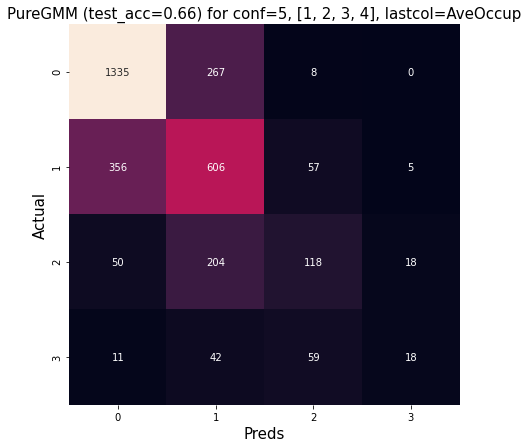

In [15]:
LAST_COL = 'AveOccup'
models = getModels(train)

preds = predict(models, train.loc[:,:LAST_COL])
print("Train accuracy: ", (train.target == preds).mean())

preds = predict(models, test.loc[:,:LAST_COL])
acc = (test.target == preds).mean()
print("Test accuracy: ", acc)

print(classification_report(test.target, preds))

cm = confusion_matrix(test.target, preds)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False)
plt.title(f"PureGMM (test_acc={acc.round(2)}) for conf={NUM_CLASSES}, {CLASSES_TO_KEEP}, lastcol={LAST_COL}", fontsize=15)
plt.xlabel('Preds', fontsize=15)
plt.ylabel('Actual', fontsize=15);

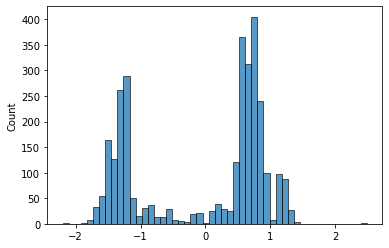

In [16]:
X = np.array(train['Longitude'][train.target == 2])
sns.histplot(X, bins=50);

In [17]:
class GaussianMixtureModel:
    def __init__(self, nclus=2, dim=1):
        self.mu = np.linspace(-2, 2, num=nclus).reshape((dim,-1))
        self.sigma = np.ones((dim, nclus))
        self.lbd  = np.ones((dim, nclus)) / nclus
        self.nclus = nclus
        self.dim = 1
        
    def normalPDF(self, X):
        """
        X is column, self.mu and self.sigma are rows.
        The shapes are chosen such that the below code looks as though it only works for scalars.
        Broadcasting allows all pairs of differences to be calculated (hence giving a matrix of pdfs)
        """
        z = (X - self.mu) / self.sigma
        dn = self.sigma * (2 * np.pi)**.5
        return np.exp(-0.5 * z**2) / dn
    
    def getGamma(self, X, normalize=True):
        N = self.normalPDF(X)
        G = self.lbd * N
        if normalize:
            G /= G.sum(axis=1, keepdims=True)
        return G
    
    def predictProba(self, X):
        X = X.reshape((-1, self.dim)) # data is a col, params are rows
        G = self.lbd * self.normalPDF(X)
        return G.sum(axis=1)
    
    def fit(self, X, n_rounds=50):
        X = X.reshape((-1, self.dim)) # data is a col, params are rows
        m, n = X.shape[0], self.nclus
        
        for _ in range(n_rounds):
            # E_step gamma_ij is [m, n]
            gamma = self.getGamma(X)
            
            # M_step assigning new values
            sumGammaI = gamma.sum(axis=0, keepdims=True) # [1, n] 
            xmu = (X-self.mu) # m, n -> m,
            self.sigma = (gamma * (X - self.mu)**2).sum(axis=0, keepdims=True) / sumGammaI # sum([m, n] * [m, n], 0) =  [1, n]
            self.sigma = self.sigma ** .5
            self.mu = (X.T @ gamma) / sumGammaI   # [1, m] @ [m, n] -> [1, n]
            self.lbd = sumGammaI / m
        return self
    
    def plot(self, X, ax):
        ax.hist(X, bins=20, density=True)
        dummyX = np.linspace(X.min(), X.max(), num=100).reshape((-1, 1))

        y = self.predictProba(dummyX)
        ax.plot(dummyX, y)
        return ax

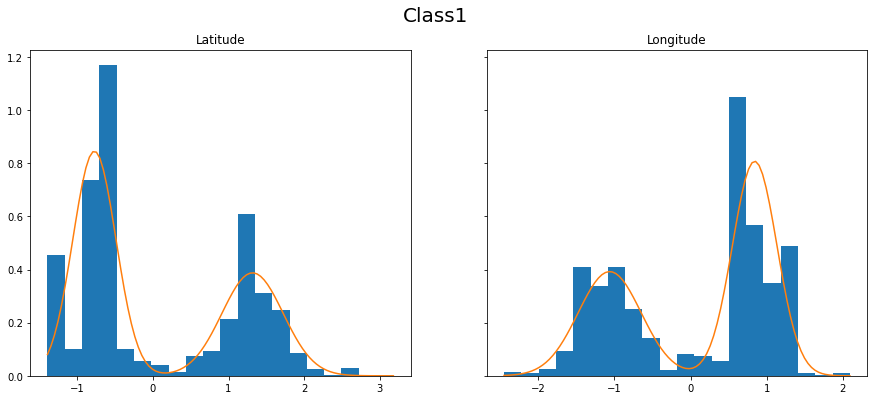

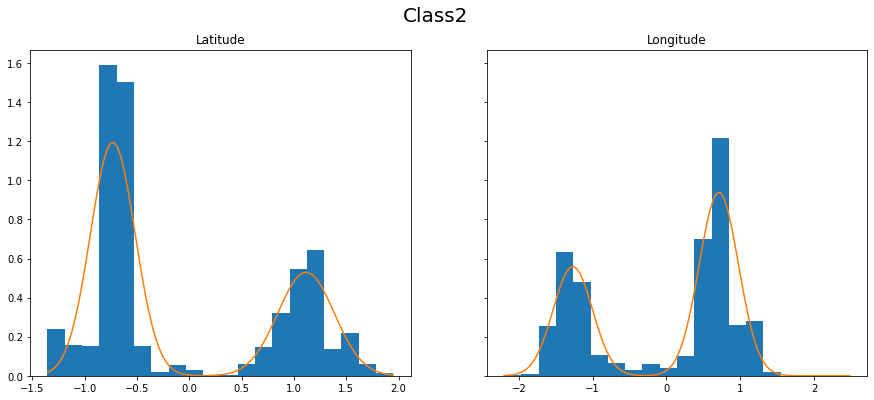

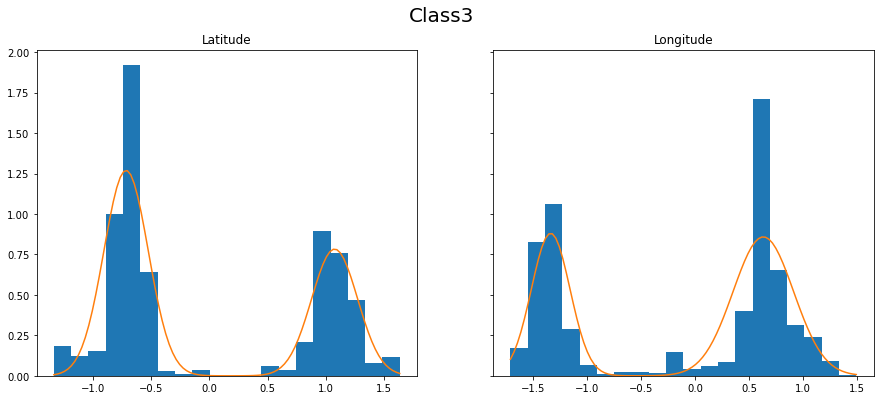

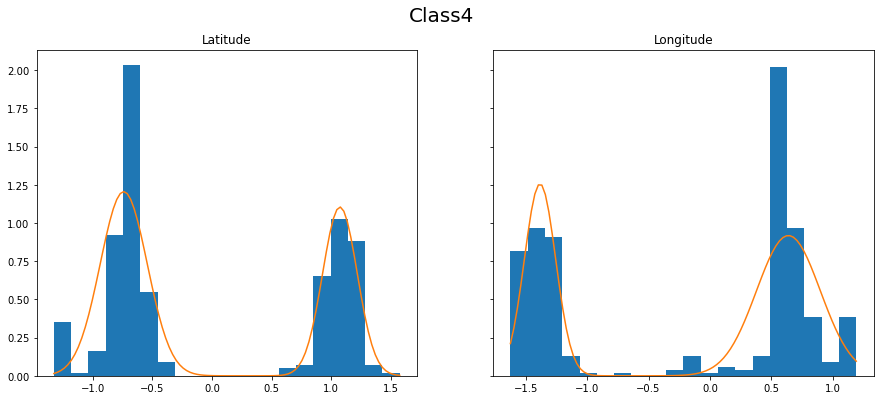

In [18]:
for c in np.unique(train.target):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    fig.suptitle(f'Class{c}', fontsize=20)
    for i, col in enumerate("Latitude Longitude".split()):
        X = np.array(train[col][train.target == c])
        model = GaussianMixtureModel().fit(X, 10)
        ax = model.plot(X, axs[i])
        ax.set_title(f'{col}')

## GMM for latitude, longitude and Gaussian for remaining

Test accuracy:  0.6509194673430564
              precision    recall  f1-score   support

           1       0.78      0.79      0.78      1610
           2       0.54      0.59      0.56      1024
           3       0.45      0.39      0.42       390
           4       0.44      0.18      0.25       130

    accuracy                           0.65      3154
   macro avg       0.55      0.49      0.51      3154
weighted avg       0.65      0.65      0.65      3154



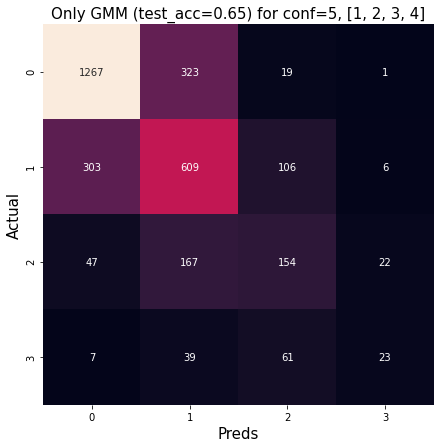

In [19]:
GaussianPart = ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'HouseAge']
GmmPart = ['Latitude', 'Longitude']

class ClassConditionalSpecialModel:
    def __init__(self, prior, mean, covInv, covDet, gmModels):
        self.prior = prior
        self.mean = mean
        self.covInv = covInv
        self.denominator = np.sqrt(covDet)
        self.gmModels = gmModels
        
    def posteriorProbScaled(self, x):
        z = np.array(x[GaussianPart] - self.mean)
        numerator = np.exp(-0.5 * np.diagonal(z @ self.covInv @ z.T) )
        gauss = numerator/self.denominator
        gmmProb = 1
        for gmCol, gmModel in zip(GmmPart, self.gmModels):
            gmmProb *= gmModel.predictProba(np.array(x[gmCol]))
#         gauss = 1
        return self.prior * gauss * gmmProb

def predict(models, x):
    idx = np.array([model.posteriorProbScaled(x) for model in models]).T.argmax(axis=1)
    return np.array(CLASSES_TO_KEEP)[idx]

def getModels(train, classes=CLASSES_TO_KEEP):
    # similar to fit function
    X = np.array(train[GaussianPart])
    y = np.array(train.target)
    
    idx = [y==i for i in classes] # X[idx[0]] gives all examples with target class 0
    priors = [j.mean() for j in idx] # priors is fraction of times each class appears in the dataset
    
    means = [ X[j].mean(axis=0) for j in idx ] #classwise means
    
    covs = [ np.cov(X[j], rowvar=False) for j in idx ]
    covInvs = [ np.linalg.inv(c) for c in covs ]
    covDets = [ np.linalg.det(c) for c in covs ]
    
    gmModels = [
        # each class has one model for lat and one for long
        [ GaussianMixtureModel().fit( np.array(train[col][j]) ) for col in GmmPart ]
        for j in idx
    ]
    return [        
        ClassConditionalSpecialModel(priors[i], means[i], covInvs[i], covDets[i], gmModels[i])
        for i in range(len(classes))
    ]

models = getModels(train)

# preds = predict(models, train.loc[:,:'Longitude'])
# print("Train accuracy: ", (train.target == preds).mean())

preds = predict(models, test.loc[:,:'Longitude'])
acc = (test.target == preds).mean()
print("Test accuracy: ", acc)
print(classification_report(test.target, preds))

cm = confusion_matrix(test.target, preds)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False)
plt.title(f"Only GMM (test_acc={acc.round(2)}) for conf={NUM_CLASSES}, {CLASSES_TO_KEEP}", fontsize=15)
plt.xlabel('Preds', fontsize=15)
plt.ylabel('Actual', fontsize=15);

Text(0.5, 1.0, 'Predicted distribution')

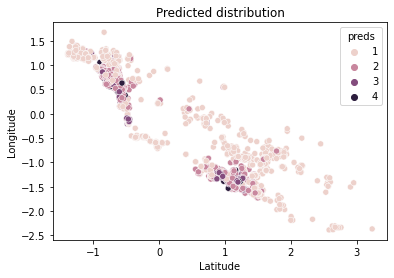

In [20]:
sns.scatterplot(x='Latitude', y='Longitude', hue='preds', data=pd.DataFrame({'Latitude':test.Latitude, 'Longitude':test.Longitude, 'preds':preds}))
plt.xlabel('Latitude')
plt.ylabel("Longitude")
plt.title('Predicted distribution')